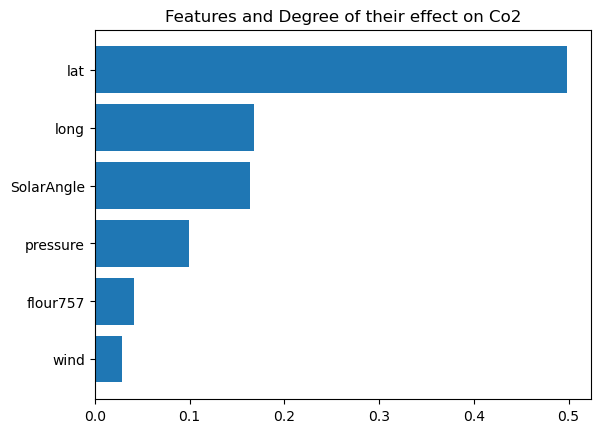

0.8077283750027298
1.0604153013247574e-12

ACTUAL CO2 CONCENTRATION FROM GIVEN OCO-2 DATA



PREDICTED CO2 CONCENTRATION FROM GIVEN OCO-2 DATA



PREDICTION FOR A SMALLER AREA
Avg co2 for taken smaller area 0.0002977352241285606


In [31]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import plotly.express as pex

#contains the oco2 satellite data(oco2_l2)
d=h5py.File('dataset.h5','r')
#selecting neccessary features from h5 file and converting them to a dataframe
t=pd.DataFrame(np.array(d['RetrievalGeometry']['retrieval_latitude']),columns=['lat'])
v=pd.DataFrame(np.array(d['RetrievalGeometry']['retrieval_longitude']),columns=['long'])
l=pd.DataFrame(np.array(d['RetrievalResults']['fluorescence_at_reference']),columns=['flour757'])
j=pd.DataFrame(np.array(d['RetrievalResults']['xco2']),columns=['xco2'])
k=pd.DataFrame(np.array(d['RetrievalGeometry']['retrieval_solar_zenith']),columns=['SolarAngle'])
p=pd.DataFrame(np.array(d['RetrievalResults']['wind_speed']),columns=['wind'])
o=pd.DataFrame(np.array(d['RetrievalResults']['tropopause_pressure']),columns=['pressure'])
f=pd.concat([t,v,p,l,k,o,j],axis=1)  #axis set to 1 stacks the dataframes side by side


X=f.drop(['xco2'],axis=1)#features
Y=f['xco2']#target variable 

#split respective train and test data for model training
#we use a decision tree based model which uses ensemble learning method
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)
Model=RandomForestRegressor(n_estimators=100,random_state=42)
Model.fit(x_train,y_train)
y_pred=Model.predict(x_test)
#the features that most affect co2 are shown as a plot
imp=Model.feature_importances_
fe=pd.DataFrame({'feature':X.columns,'imp':imp})
d=fe.sort_values('imp',ascending=True)
plt.barh(d['feature'],d['imp'])
plt.title("Features and Degree of their effect on Co2")
plt.show()

#r2 score denotes how well the regression model has performed(fits to regression line)

error=mean_squared_error(y_test,y_pred)
score=r2_score(y_test,y_pred)
print(score)
print(error)


#create datasets for predicted and actual co2 values
p=pd.DataFrame({'co2_actual':y_test})
test=pd.concat([t,v,p],axis=1)
test=test.dropna()#we had to drop null from y_test and y_pred to get better results
p=pd.DataFrame({'co2_pred':y_pred})
pred=pd.concat([t,v,p],axis=1)
pred=pred.dropna()

#creates mapbox with actualt co2 data and displays legend along with it
#Each point when hovered on shows the latitude longitude and xco2 concentration present 

test_fig=pex.scatter_mapbox(test,lat='lat',lon='long',color='co2_actual',size_max=15,color_continuous_scale="gray",zoom=3,height=700)
test_fig.update_layout(mapbox_style="open-street-map")
test_fig.update_layout(coloraxis_colorbar=dict(title="Actual Co2 Concentration",thicknessmode="pixels",thickness=15,lenmode="pixels",len=300,yanchor="top",y=1.0,xanchor="left",x=1.2))
print("\nACTUAL CO2 CONCENTRATION FROM GIVEN OCO-2 DATA")
test_fig.show()

pred_fig=pex.scatter_mapbox(pred,lat='lat',lon='long',color='co2_pred',size_max=15,color_continuous_scale="armyrose",zoom=3,height=700)
pred_fig.update_layout(mapbox_style="open-street-map")
pred_fig.update_layout(coloraxis_colorbar=dict(title="Predicted Co2 Concentration",thicknessmode="pixels",thickness=15,lenmode="pixels",len=300,yanchor="top",y=1.0,xanchor="left",x=1.2))
print("\nPREDICTED CO2 CONCENTRATION FROM GIVEN OCO-2 DATA")
pred_fig.show()

print("\nPREDICTION FOR A SMALLER AREA")
small=f.iloc[0:201,:7]

X=small.drop(['xco2'],axis=1)#features
Y=small['xco2']#target variable 
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)
small_pred=Model.predict(x_test)
co2=(sum(small_pred)/len(small_pred))*0.74
print("Avg co2 for taken smaller area",co2)
#We take a small subset of the large dataset as the smaller region behaviour
#we extrapolate xco2 value using the previously trained larger model
#we predict an xco2(average)value for the assumed region

#The constant value 0.4 is multiplied beacuse when we extract smaller data from larger data
#The larger data tends to be more accurate so to make our predicted value have better accuracy 
#we take a common range 0.4 to improve accuracy of predicted(xco2)average 